<a href="https://colab.research.google.com/github/doouv/2025-KIChe-PSE-Summer-School-Tutorial/blob/main/Hands_on_practice__GeoDiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **🚩Introduction**

<img src="https://github.com/MinkaiXu/GeoDiff/raw/main/assets/geodiff_framework.png" width="800px">

*   This colab is design to run the pretrained models from [GeoDiff](https://github.com/MinkaiXu/GeoDiff).
*   The visualization code is inspired by this PyMol [colab](https://colab.research.google.com/gist/iwatobipen/2ec7faeafe5974501e69fcc98c122922/pymol.ipynb#scrollTo=Hm4kY7CaZSlw).

*   The goal is to generate physically accurate molecules. Given the input of a molecule graph (atom and bond structures with their connectivity -- in the form of a 2d graph). What we want to generate is a stable 3d structure of the molecule.

*   This colab uses GEOM datasets that have multiple 3d targets per configuration, which provide more compelling targets for generative methods.

> [Original colab tutotial](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/geodiff_molecule_conformation.ipynb) made by [natolambert](https://twitter.com/natolambert); **this version was updated for the 2025 KiChe PSE Summer School** by TA [Hayoung Doo](https://github.com/doouv/2025-KIChe-PSE-Summer-School-Tutorial) with academic supervision from [Prof. Jonggeol Na](https://nagroup.ewha.ac.kr/).
>
> Library: [Hugging Face Diffusers](colab.research.google.com/drive/1oCSVfMhWrqHTeHbKgUSQN9hTKxLzoNyb?pli=1#scrollTo=QiAR1bg1D2yH)

---
\
<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41597-022-01288-4/MediaObjects/41597_2022_1288_Fig1_HTML.png?as=webp" width="600px">

Adapted from [Axelrod, S., Gómez-Bombarelli, R. et al.,Sci Data 9, 185 (2022)](https://www.nature.com/articles/s41597-022-01288-4#citeas)

## **🎯 Problem description**

*   A single 2D chemical structure can correspond to multiple 3D conformers.

*   These conformers must satisfy chemical constraints such as bond lengths, bond angles, steric repulsion, and steric hindrance.

*   However, naive sampling often produces a large number of chemically invalid structures.

Therefore, the goal is to learn the mapping from a 2D chemical structure to a physically valid distribution of 3D conformers, enabling generation through sampling.

# 📥 **Installations**



### Install Geometric Dependencies

Here we check the **CUDA** and **PyTorch** versions on colab. As of Aug 2025, Colab used python 3.11; install a PyTorch build compatible with python 3.11 (i.e.,≥ 2.0).

In [32]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [33]:
import torch
print(f"\n📢 PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


📢 PyTorch version: 2.8.0+cu126
CUDA available: True


Install **PyTorch Geometric (PyG)** that matches the **PyTorch + CUDA** versions printed above.
If your versions differ, replace the wheel index at the end of the command
(e.g., `torch-2.6.0+cu124.html`) with the one that matches your environment.

+) [2025.08.20] torch and cuda version is updated to 2.8.0+cu126


In [34]:
!pip install torch_geometric
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.8.0+cu126.html

Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html


### Install Diffusers

In [35]:
# diffuers & dependencies for diffusers
!pip install -q -U diffusers transformers  datasets

### Install Chemistry-specific Dependencies

Install RDKit, a tool for working with and visualizing chemsitry in python (you use this to visualize the generate models later).

In [36]:
!pip install rdkit

# **🛠️ Create a diffusion model**

### Model class(es)

GeoDiff uses a Graph Field Network (GFN) as its backbone, wrapped within a framework called MoleculeGNN.
MoleculeGNN contains both a global and a local branch to capture the overall atomic environment from different perspectives.
Each branch employs a distinct type of machine learning potential models: the global branch uses [SchNet](https://arxiv.org/abs/1706.08566), while the local branch is based on the [Graph Isomorphism Network (GIN)](https://arxiv.org/pdf/1810.00826).

### **What is Graph Field Network (GFN)?**
*   A graph field network (GFN) is a neural network layer that takes a graph — with nodes, edges, and 3D geometry — and **produces a vector field over the nodes that is equivariant to rotations and translations**.
*   It does this by predicting a scalar value for each edge, multiplying it by the unit vector along that edge, and summing over neighbors.
*   The result is a per-node 3D vector that changes consistently when the whole molecule is rotated or translated.

🔻Below is the schematic diagram of the MoleculeGNN architecture. Let’s map each component to its corresponding part in the code!

<img src="https://drive.google.com/uc?export=view&id=1C6SLpQcz5Fv6SF95XreEIwOjLZvj4GhE" width=700>

Imports

In [37]:
# Model adapted from GeoDiff https://github.com/MinkaiXu/GeoDiff
# Model inspired by https://github.com/DeepGraphLearning/torchdrug/tree/master/torchdrug/models
from dataclasses import dataclass
from typing import Callable, Tuple, Union

import numpy as np
import torch
import torch.nn.functional as F
from torch import Tensor, nn
from torch.nn import Embedding, Linear, Module, ModuleList, Sequential

from torch_geometric.nn import MessagePassing, radius, radius_graph
from torch_geometric.typing import Adj, OptPairTensor, OptTensor, Size
from torch_geometric.utils import dense_to_sparse, to_dense_adj
from torch_scatter import scatter_add
from torch_sparse import SparseTensor, coalesce

from diffusers.configuration_utils import ConfigMixin, register_to_config
from diffusers.models.modeling_utils import ModelMixin
from diffusers.utils import BaseOutput


Helper classes

In [38]:
@dataclass
class MoleculeGNNOutput(BaseOutput):
    """
    Args:
        sample (`torch.FloatTensor` of shape `(batch_size, num_channels, height, width)`):
            Hidden states output. Output of last layer of model.
    """

    sample: torch.FloatTensor


class MultiLayerPerceptron(nn.Module):
    """
    Multi-layer Perceptron. Note there is no activation or dropout in the last layer.
    Args:
        input_dim (int): input dimension
        hidden_dim (list of int): hidden dimensions
        activation (str or function, optional): activation function
        dropout (float, optional): dropout rate
    """

    def __init__(self, input_dim, hidden_dims, activation="relu", dropout=0):
        super(MultiLayerPerceptron, self).__init__()

        self.dims = [input_dim] + hidden_dims
        if isinstance(activation, str):
            self.activation = getattr(F, activation)
        else:
            print(f"Warning, activation passed {activation} is not string and ignored")
            self.activation = None
        if dropout > 0:
            self.dropout = nn.Dropout(dropout)
        else:
            self.dropout = None

        self.layers = nn.ModuleList()
        for i in range(len(self.dims) - 1):
            self.layers.append(nn.Linear(self.dims[i], self.dims[i + 1]))

    def forward(self, x):
        """"""
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers) - 1:
                if self.activation:
                    x = self.activation(x)
                if self.dropout:
                    x = self.dropout(x)
        return x


class ShiftedSoftplus(torch.nn.Module):
    def __init__(self):
        super(ShiftedSoftplus, self).__init__()
        self.shift = torch.log(torch.tensor(2.0)).item()

    def forward(self, x):
        return F.softplus(x) - self.shift


class CFConv(MessagePassing):
    def __init__(self, in_channels, out_channels, num_filters, mlp, cutoff, smooth):
        super(CFConv, self).__init__(aggr="add")
        self.lin1 = Linear(in_channels, num_filters, bias=False)
        self.lin2 = Linear(num_filters, out_channels)
        self.nn = mlp
        self.cutoff = cutoff
        self.smooth = smooth

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.lin1.weight)
        torch.nn.init.xavier_uniform_(self.lin2.weight)
        self.lin2.bias.data.fill_(0)

    def forward(self, x, edge_index, edge_length, edge_attr):
        if self.smooth:
            C = 0.5 * (torch.cos(edge_length * np.pi / self.cutoff) + 1.0)
            C = C * (edge_length <= self.cutoff) * (edge_length >= 0.0)  # Modification: cutoff
        else:
            C = (edge_length <= self.cutoff).float()
        W = self.nn(edge_attr) * C.view(-1, 1)

        x = self.lin1(x)
        x = self.propagate(edge_index, x=x, W=W)
        x = self.lin2(x)
        return x

    def message(self, x_j: torch.Tensor, W) -> torch.Tensor:
        return x_j * W


class InteractionBlock(torch.nn.Module):
    def __init__(self, hidden_channels, num_gaussians, num_filters, cutoff, smooth):
        super(InteractionBlock, self).__init__()
        mlp = Sequential(
            Linear(num_gaussians, num_filters),
            ShiftedSoftplus(),
            Linear(num_filters, num_filters),
        )
        self.conv = CFConv(hidden_channels, hidden_channels, num_filters, mlp, cutoff, smooth)
        self.act = ShiftedSoftplus()
        self.lin = Linear(hidden_channels, hidden_channels)

    def forward(self, x, edge_index, edge_length, edge_attr):
        x = self.conv(x, edge_index, edge_length, edge_attr)
        x = self.act(x)
        x = self.lin(x)
        return x


class SchNetEncoder(Module):
    def __init__(
        self, hidden_channels=128, num_filters=128, num_interactions=6, edge_channels=100, cutoff=10.0, smooth=False
    ):
        super().__init__()

        self.hidden_channels = hidden_channels
        self.num_filters = num_filters
        self.num_interactions = num_interactions
        self.cutoff = cutoff

        self.embedding = Embedding(100, hidden_channels, max_norm=10.0)

        self.interactions = ModuleList()
        for _ in range(num_interactions):
            block = InteractionBlock(hidden_channels, edge_channels, num_filters, cutoff, smooth)
            self.interactions.append(block)

    def forward(self, z, edge_index, edge_length, edge_attr, embed_node=True):
        if embed_node:
            assert z.dim() == 1 and z.dtype == torch.long
            h = self.embedding(z)
        else:
            h = z
        for interaction in self.interactions:
            h = h + interaction(h, edge_index, edge_length, edge_attr)

        return h


class GINEConv(MessagePassing):
    """
    Custom class of the graph isomorphism operator from the "How Powerful are Graph Neural Networks?
    https://arxiv.org/abs/1810.00826 paper. Note that this implementation has the added option of a custom activation.
    """

    def __init__(self, mlp: Callable, eps: float = 0.0, train_eps: bool = False, activation="softplus", **kwargs):
        super(GINEConv, self).__init__(aggr="add", **kwargs)
        self.nn = mlp
        self.initial_eps = eps

        if isinstance(activation, str):
            self.activation = getattr(F, activation)
        else:
            self.activation = None

        if train_eps:
            self.eps = torch.nn.Parameter(torch.Tensor([eps]))
        else:
            self.register_buffer("eps", torch.Tensor([eps]))

    def forward(
        self, x: Union[Tensor, OptPairTensor], edge_index: Adj, edge_attr: OptTensor = None, size: Size = None
    ) -> torch.Tensor:
        """"""
        if isinstance(x, torch.Tensor):
            x: OptPairTensor = (x, x)

        # Node and edge feature dimensionalites need to match.
        if isinstance(edge_index, torch.Tensor):
            assert edge_attr is not None
            assert x[0].size(-1) == edge_attr.size(-1)
        elif isinstance(edge_index, SparseTensor):
            assert x[0].size(-1) == edge_index.size(-1)

        # propagate_type: (x: OptPairTensor, edge_attr: OptTensor)
        out = self.propagate(edge_index, x=x, edge_attr=edge_attr, size=size)

        x_r = x[1]
        if x_r is not None:
            out += (1 + self.eps) * x_r

        return self.nn(out)

    def message(self, x_j: torch.Tensor, edge_attr: torch.Tensor) -> torch.Tensor:
        if self.activation:
            return self.activation(x_j + edge_attr)
        else:
            return x_j + edge_attr

    def __repr__(self):
        return "{}(nn={})".format(self.__class__.__name__, self.nn)


class GINEncoder(torch.nn.Module):
    def __init__(self, hidden_dim, num_convs=3, activation="relu", short_cut=True, concat_hidden=False):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.num_convs = num_convs
        self.short_cut = short_cut
        self.concat_hidden = concat_hidden
        self.node_emb = nn.Embedding(100, hidden_dim)

        if isinstance(activation, str):
            self.activation = getattr(F, activation)
        else:
            self.activation = None

        self.convs = nn.ModuleList()
        for i in range(self.num_convs):
            self.convs.append(
                GINEConv(
                    MultiLayerPerceptron(hidden_dim, [hidden_dim, hidden_dim], activation=activation),
                    activation=activation,
                )
            )

    def forward(self, z, edge_index, edge_attr):
        """
        Input:
            data: (torch_geometric.data.Data): batched graph edge_index: bond indices of the original graph (num_node,
            hidden) edge_attr: edge feature tensor with shape (num_edge, hidden)
        Output:
            node_feature: graph feature
        """

        node_attr = self.node_emb(z)  # (num_node, hidden)

        hiddens = []
        conv_input = node_attr  # (num_node, hidden)

        for conv_idx, conv in enumerate(self.convs):
            hidden = conv(conv_input, edge_index, edge_attr)
            if conv_idx < len(self.convs) - 1 and self.activation is not None:
                hidden = self.activation(hidden)
            assert hidden.shape == conv_input.shape
            if self.short_cut and hidden.shape == conv_input.shape:
                hidden += conv_input

            hiddens.append(hidden)
            conv_input = hidden

        if self.concat_hidden:
            node_feature = torch.cat(hiddens, dim=-1)
        else:
            node_feature = hiddens[-1]

        return node_feature


class MLPEdgeEncoder(Module):
    def __init__(self, hidden_dim=100, activation="relu"):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.bond_emb = Embedding(100, embedding_dim=self.hidden_dim)
        self.mlp = MultiLayerPerceptron(1, [self.hidden_dim, self.hidden_dim], activation=activation)

    @property
    def out_channels(self):
        return self.hidden_dim

    def forward(self, edge_length, edge_type):
        """
        Input:
            edge_length: The length of edges, shape=(E, 1). edge_type: The type pf edges, shape=(E,)
        Returns:
            edge_attr: The representation of edges. (E, 2 * num_gaussians)
        """
        d_emb = self.mlp(edge_length)  # (num_edge, hidden_dim)
        edge_attr = self.bond_emb(edge_type)  # (num_edge, hidden_dim)
        return d_emb * edge_attr  # (num_edge, hidden)


def assemble_atom_pair_feature(node_attr, edge_index, edge_attr):
    h_row, h_col = node_attr[edge_index[0]], node_attr[edge_index[1]]
    h_pair = torch.cat([h_row * h_col, edge_attr], dim=-1)  # (E, 2H)
    return h_pair


def _extend_graph_order(num_nodes, edge_index, edge_type, order=3):
    """
    Args:
        num_nodes:  Number of atoms.
        edge_index: Bond indices of the original graph.
        edge_type:  Bond types of the original graph.
        order:  Extension order.
    Returns:
        new_edge_index: Extended edge indices. new_edge_type: Extended edge types.
    """

    def binarize(x):
        return torch.where(x > 0, torch.ones_like(x), torch.zeros_like(x))

    def get_higher_order_adj_matrix(adj, order):
        """
        Args:
            adj:        (N, N)
            type_mat:   (N, N)
        Returns:
            Following attributes will be updated:
              - edge_index
              - edge_type
            Following attributes will be added to the data object:
              - bond_edge_index: Original edge_index.
        """
        adj_mats = [
            torch.eye(adj.size(0), dtype=torch.long, device=adj.device),
            binarize(adj + torch.eye(adj.size(0), dtype=torch.long, device=adj.device)),
        ]

        for i in range(2, order + 1):
            adj_mats.append(binarize(adj_mats[i - 1] @ adj_mats[1]))
        order_mat = torch.zeros_like(adj)

        for i in range(1, order + 1):
            order_mat += (adj_mats[i] - adj_mats[i - 1]) * i

        return order_mat

    num_types = 22
    # given from len(BOND_TYPES), where BOND_TYPES = {t: i for i, t in enumerate(BT.names.values())}
    # from rdkit.Chem.rdchem import BondType as BT
    N = num_nodes
    adj = to_dense_adj(edge_index).squeeze(0)
    adj_order = get_higher_order_adj_matrix(adj, order)  # (N, N)

    type_mat = to_dense_adj(edge_index, edge_attr=edge_type).squeeze(0)  # (N, N)
    type_highorder = torch.where(adj_order > 1, num_types + adj_order - 1, torch.zeros_like(adj_order))
    assert (type_mat * type_highorder == 0).all()
    type_new = type_mat + type_highorder

    new_edge_index, new_edge_type = dense_to_sparse(type_new)
    _, edge_order = dense_to_sparse(adj_order)

    # data.bond_edge_index = data.edge_index  # Save original edges
    new_edge_index, new_edge_type = coalesce(new_edge_index, new_edge_type.long(), N, N)  # modify data

    return new_edge_index, new_edge_type


def _extend_to_radius_graph(pos, edge_index, edge_type, cutoff, batch, unspecified_type_number=0, is_sidechain=None):
    assert edge_type.dim() == 1
    N = pos.size(0)

    bgraph_adj = torch.sparse.LongTensor(edge_index, edge_type, torch.Size([N, N]))

    if is_sidechain is None:
        rgraph_edge_index = radius_graph(pos, r=cutoff, batch=batch)  # (2, E_r)
    else:
        # fetch sidechain and its batch index
        is_sidechain = is_sidechain.bool()
        dummy_index = torch.arange(pos.size(0), device=pos.device)
        sidechain_pos = pos[is_sidechain]
        sidechain_index = dummy_index[is_sidechain]
        sidechain_batch = batch[is_sidechain]

        assign_index = radius(x=pos, y=sidechain_pos, r=cutoff, batch_x=batch, batch_y=sidechain_batch)
        r_edge_index_x = assign_index[1]
        r_edge_index_y = assign_index[0]
        r_edge_index_y = sidechain_index[r_edge_index_y]

        rgraph_edge_index1 = torch.stack((r_edge_index_x, r_edge_index_y))  # (2, E)
        rgraph_edge_index2 = torch.stack((r_edge_index_y, r_edge_index_x))  # (2, E)
        rgraph_edge_index = torch.cat((rgraph_edge_index1, rgraph_edge_index2), dim=-1)  # (2, 2E)
        # delete self loop
        rgraph_edge_index = rgraph_edge_index[:, (rgraph_edge_index[0] != rgraph_edge_index[1])]

    rgraph_adj = torch.sparse.LongTensor(
        rgraph_edge_index,
        torch.ones(rgraph_edge_index.size(1)).long().to(pos.device) * unspecified_type_number,
        torch.Size([N, N]),
    )

    composed_adj = (bgraph_adj + rgraph_adj).coalesce()  # Sparse (N, N, T)

    new_edge_index = composed_adj.indices()
    new_edge_type = composed_adj.values().long()

    return new_edge_index, new_edge_type


def extend_graph_order_radius(
    num_nodes,
    pos,
    edge_index,
    edge_type,
    batch,
    order=3,
    cutoff=10.0,
    extend_order=True,
    extend_radius=True,
    is_sidechain=None,
):
    if extend_order:
        edge_index, edge_type = _extend_graph_order(
            num_nodes=num_nodes, edge_index=edge_index, edge_type=edge_type, order=order
        )

    if extend_radius:
        edge_index, edge_type = _extend_to_radius_graph(
            pos=pos, edge_index=edge_index, edge_type=edge_type, cutoff=cutoff, batch=batch, is_sidechain=is_sidechain
        )

    return edge_index, edge_type


def get_distance(pos, edge_index):
    return (pos[edge_index[0]] - pos[edge_index[1]]).norm(dim=-1)


def graph_field_network(score_d, pos, edge_index, edge_length):
    """
    Transformation to make the epsilon predicted from the diffusion model roto-translational equivariant. See equations
    5-7 of the GeoDiff Paper https://arxiv.org/pdf/2203.02923.pdf
    """
    N = pos.size(0)
    dd_dr = (1.0 / edge_length) * (pos[edge_index[0]] - pos[edge_index[1]])  # (E, 3)
    score_pos = scatter_add(dd_dr * score_d, edge_index[0], dim=0, dim_size=N) + scatter_add(
        -dd_dr * score_d, edge_index[1], dim=0, dim_size=N
    )  # (N, 3)
    return score_pos


def clip_norm(vec, limit, p=2):
    norm = torch.norm(vec, dim=-1, p=2, keepdim=True)
    denom = torch.where(norm > limit, limit / norm, torch.ones_like(norm))
    return vec * denom


def is_local_edge(edge_type):
    return edge_type > 0


Main model class!

In [39]:
class MoleculeGNN(ModelMixin, ConfigMixin):
    @register_to_config
    def __init__(
        self,
        hidden_dim=128,
        num_convs=6,
        num_convs_local=4,
        cutoff=10.0,
        mlp_act="relu",
        edge_order=3,
        edge_encoder="mlp",
        smooth_conv=True,
    ):
        super().__init__()
        self.cutoff = cutoff
        self.edge_encoder = edge_encoder
        self.edge_order = edge_order

        """
        edge_encoder: Takes both edge type and edge length as input and outputs a vector [Note]: node embedding is done
        in SchNetEncoder
        """
        self.edge_encoder_global = MLPEdgeEncoder(hidden_dim, mlp_act)  # get_edge_encoder(config)
        self.edge_encoder_local = MLPEdgeEncoder(hidden_dim, mlp_act)  # get_edge_encoder(config)

        """
        The graph neural network that extracts node-wise features.
        """
        self.encoder_global = SchNetEncoder(
            hidden_channels=hidden_dim,
            num_filters=hidden_dim,
            num_interactions=num_convs,
            edge_channels=self.edge_encoder_global.out_channels,
            cutoff=cutoff,
            smooth=smooth_conv,
        )
        self.encoder_local = GINEncoder(
            hidden_dim=hidden_dim,
            num_convs=num_convs_local,
        )

        """
        `output_mlp` takes a mixture of two nodewise features and edge features as input and outputs
            gradients w.r.t. edge_length (out_dim = 1).
        """
        self.grad_global_dist_mlp = MultiLayerPerceptron(
            2 * hidden_dim, [hidden_dim, hidden_dim // 2, 1], activation=mlp_act
        )

        self.grad_local_dist_mlp = MultiLayerPerceptron(
            2 * hidden_dim, [hidden_dim, hidden_dim // 2, 1], activation=mlp_act
        )

        """
        Incorporate parameters together
        """
        self.model_global = nn.ModuleList([self.edge_encoder_global, self.encoder_global, self.grad_global_dist_mlp])
        self.model_local = nn.ModuleList([self.edge_encoder_local, self.encoder_local, self.grad_local_dist_mlp])

    def _forward(
        self,
        atom_type,
        pos,
        bond_index,
        bond_type,
        batch,
        time_step,  # NOTE, model trained without timestep performed best
        edge_index=None,
        edge_type=None,
        edge_length=None,
        return_edges=False,
        extend_order=True,
        extend_radius=True,
        is_sidechain=None,
    ):
        """
        Args:
            atom_type:  Types of atoms, (N, ).
            bond_index: Indices of bonds (not extended, not radius-graph), (2, E).
            bond_type:  Bond types, (E, ).
            batch:      Node index to graph index, (N, ).
        """
        N = atom_type.size(0)
        if edge_index is None or edge_type is None or edge_length is None:
            edge_index, edge_type = extend_graph_order_radius(
                num_nodes=N,
                pos=pos,
                edge_index=bond_index,
                edge_type=bond_type,
                batch=batch,
                order=self.edge_order,
                cutoff=self.cutoff,
                extend_order=extend_order,
                extend_radius=extend_radius,
                is_sidechain=is_sidechain,
            )
            edge_length = get_distance(pos, edge_index).unsqueeze(-1)  # (E, 1)
        local_edge_mask = is_local_edge(edge_type)  # (E, )

        # with the parameterization of NCSNv2
        # DDPM loss implicit handle the noise variance scale conditioning
        sigma_edge = torch.ones(size=(edge_index.size(1), 1), device=pos.device)  # (E, 1)

        # Encoding global
        edge_attr_global = self.edge_encoder_global(edge_length=edge_length, edge_type=edge_type)  # Embed edges

        # Global
        node_attr_global = self.encoder_global(
            z=atom_type,
            edge_index=edge_index,
            edge_length=edge_length,
            edge_attr=edge_attr_global,
        )
        # Assemble pairwise features
        h_pair_global = assemble_atom_pair_feature(
            node_attr=node_attr_global,
            edge_index=edge_index,
            edge_attr=edge_attr_global,
        )  # (E_global, 2H)
        # Invariant features of edges (radius graph, global)
        edge_inv_global = self.grad_global_dist_mlp(h_pair_global) * (1.0 / sigma_edge)  # (E_global, 1)

        # Encoding local
        edge_attr_local = self.edge_encoder_global(edge_length=edge_length, edge_type=edge_type)  # Embed edges
        # edge_attr += temb_edge

        # Local
        node_attr_local = self.encoder_local(
            z=atom_type,
            edge_index=edge_index[:, local_edge_mask],
            edge_attr=edge_attr_local[local_edge_mask],
        )
        # Assemble pairwise features
        h_pair_local = assemble_atom_pair_feature(
            node_attr=node_attr_local,
            edge_index=edge_index[:, local_edge_mask],
            edge_attr=edge_attr_local[local_edge_mask],
        )  # (E_local, 2H)

        # Invariant features of edges (bond graph, local)
        if isinstance(sigma_edge, torch.Tensor):
            edge_inv_local = self.grad_local_dist_mlp(h_pair_local) * (
                1.0 / sigma_edge[local_edge_mask]
            )  # (E_local, 1)
        else:
            edge_inv_local = self.grad_local_dist_mlp(h_pair_local) * (1.0 / sigma_edge)  # (E_local, 1)

        if return_edges:
            return edge_inv_global, edge_inv_local, edge_index, edge_type, edge_length, local_edge_mask
        else:
            return edge_inv_global, edge_inv_local

    def forward(
        self,
        sample,
        timestep: Union[torch.Tensor, float, int],
        return_dict: bool = True,
        sigma=1.0,
        global_start_sigma=0.5,
        w_global=1.0,
        extend_order=False,
        extend_radius=True,
        clip_local=None,
        clip_global=1000.0,
    ) -> Union[MoleculeGNNOutput, Tuple]:
        r"""
        Args:
            sample: packed torch geometric object
            timestep (`torch.FloatTensor` or `float` or `int): TODO verify type and shape (batch) timesteps
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~models.molecule_gnn.MoleculeGNNOutput`] instead of a plain tuple.
        Returns:
            [`~models.molecule_gnn.MoleculeGNNOutput`] or `tuple`: [`~models.molecule_gnn.MoleculeGNNOutput`] if
            `return_dict` is True, otherwise a `tuple`. When returning a tuple, the first element is the sample tensor.
        """

        # unpack sample
        atom_type = sample.atom_type
        bond_index = sample.edge_index
        bond_type = sample.edge_type
        num_graphs = sample.num_graphs
        pos = sample.pos

        timesteps = torch.full(size=(num_graphs,), fill_value=timestep, dtype=torch.long, device=pos.device)

        edge_inv_global, edge_inv_local, edge_index, edge_type, edge_length, local_edge_mask = self._forward(
            atom_type=atom_type,
            pos=sample.pos,
            bond_index=bond_index,
            bond_type=bond_type,
            batch=sample.batch,
            time_step=timesteps,
            return_edges=True,
            extend_order=extend_order,
            extend_radius=extend_radius,
        )  # (E_global, 1), (E_local, 1)

        # Important equation in the paper for equivariant features - eqns 5-7 of GeoDiff
        node_eq_local = graph_field_network(
            edge_inv_local, pos, edge_index[:, local_edge_mask], edge_length[local_edge_mask]
        )
        if clip_local is not None:
            node_eq_local = clip_norm(node_eq_local, limit=clip_local)

        # Global
        if sigma < global_start_sigma:
            edge_inv_global = edge_inv_global * (1 - local_edge_mask.view(-1, 1).float())
            node_eq_global = graph_field_network(edge_inv_global, pos, edge_index, edge_length)
            node_eq_global = clip_norm(node_eq_global, limit=clip_global)
        else:
            node_eq_global = 0

        # Sum
        eps_pos = node_eq_local + node_eq_global * w_global

        if not return_dict:
            return (-eps_pos,)

        return MoleculeGNNOutput(sample=torch.FloatTensor(-eps_pos).to(pos.device))

### Load pretrained model

#### Load a model
The model used is a design an
equivariant convolutional layer, named graph field network (GFN).

The warning about `betas` and `alphas` can be ignored, those were moved to the scheduler.

In [40]:
DEVICE = 'cuda'
model = MoleculeGNN.from_pretrained("fusing/gfn-molecule-gen-drugs").to(DEVICE)

An error occurred while trying to fetch fusing/gfn-molecule-gen-drugs: fusing/gfn-molecule-gen-drugs does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
The config attributes {'type': 'diffusion', 'network': 'dualenc', 'beta_schedule': 'sigmoid', 'beta_start': 1e-07, 'beta_end': 0.002, 'num_diffusion_timesteps': 5000} were passed to MoleculeGNN, but are not expected and will be ignored. Please verify your config.json configuration file.
Some weights of the model checkpoint at fusing/gfn-molecule-gen-drugs were not used when initializing MoleculeGNN: 
 ['betas, alphas']


In [41]:
print(model)

MoleculeGNN(
  (edge_encoder_global): MLPEdgeEncoder(
    (bond_emb): Embedding(100, 128)
    (mlp): MultiLayerPerceptron(
      (layers): ModuleList(
        (0): Linear(in_features=1, out_features=128, bias=True)
        (1): Linear(in_features=128, out_features=128, bias=True)
      )
    )
  )
  (edge_encoder_local): MLPEdgeEncoder(
    (bond_emb): Embedding(100, 128)
    (mlp): MultiLayerPerceptron(
      (layers): ModuleList(
        (0): Linear(in_features=1, out_features=128, bias=True)
        (1): Linear(in_features=128, out_features=128, bias=True)
      )
    )
  )
  (encoder_global): SchNetEncoder(
    (embedding): Embedding(100, 128, max_norm=10.0)
    (interactions): ModuleList(
      (0-5): 6 x InteractionBlock(
        (conv): CFConv()
        (act): ShiftedSoftplus()
        (lin): Linear(in_features=128, out_features=128, bias=True)
      )
    )
  )
  (encoder_local): GINEncoder(
    (node_emb): Embedding(100, 128)
    (convs): ModuleList(
      (0-3): 4 x GINEConv(

The warnings above are because the pre-trained model was uploaded before cleaning the code!

#### Create scheduler
Note, other schedulers are used in the paper for slightly improved performance over DDPM.

In [42]:
from diffusers import DDPMScheduler

In [43]:
num_timesteps = 1000
scheduler = DDPMScheduler(num_train_timesteps=num_timesteps,beta_schedule="sigmoid",beta_start=1e-7, beta_end=2e-3, clip_sample=False)

### Get a dataset

Load the dataset with torch.

In [44]:
import torch, pickle
from rdkit import Chem
import networkx as nx
torch.serialization.add_safe_globals([Chem.Mol, Chem.rdchem.Mol, nx.Graph, nx.DiGraph]) # For safe-load

In [45]:
!wget -q https://huggingface.co/datasets/fusing/geodiff-example-data/resolve/main/data/molecules.pkl -O molecules.pkl
dataset = torch.load("molecules.pkl")

Since the `dataset` object is a legacy PyG dataset, it needs to be migrated to the current API.

In [46]:
from torch_geometric.data import Data

def convert_old_pyg_to_new(old_data):
    if isinstance(old_data, Data) and hasattr(old_data.__dict__, '_store'):
        return old_data

    new_data = Data()

    old_dict = getattr(old_data, '__dict__', {})
    for key, value in old_dict.items():
        if not key.startswith('_') and value is not None:
            setattr(new_data, key, value)

    # num_nodes inference
    if not hasattr(new_data, 'num_nodes') or new_data.num_nodes is None:
        # confim in an order of pos_ref-> x-> pos
        for attr in ['pos_ref', 'x', 'pos']:
            if hasattr(new_data, attr):
                tensor = getattr(new_data, attr)
                if tensor is not None:
                    new_data.num_nodes = int(tensor.size(0))
                    break

    return new_data

In [47]:
dataset = [convert_old_pyg_to_new(data) for data in dataset]

Print out one entry of the dataset, it contains molecular formulas, atom types, positions, and more.

In [48]:
print(f"Total molecules: {len(dataset)}")
dataset[0]

Total molecules: 5


Data(edge_index=[2, 598], pos=[51, 3], atom_type=[51], edge_type=[598], rdmol=<rdkit.Chem.rdchem.Mol object at 0x7a5b683c9d00>, smiles='CC1CCCN(C(=O)C2CCN(S(=O)(=O)c3cccc4nonc34)CC2)C1', nx=Graph with 51 nodes and 54 edges, idx=[1], pos_ref=[255, 3], num_pos_ref=[1], num_nodes_per_graph=[1], bond_edge_index=[2, 108], edge_order=[598], is_bond=[598])

In [49]:
# dataset[0]['pos']

# **🧠 Run the diffusion process**

#### Helper Functions

In [50]:
from torch_geometric.data import Data, Batch
from torch_scatter import scatter_add, scatter_mean
from tqdm import tqdm
import copy
import os

def repeat_data(data: Data, num_repeat) -> Batch:
    datas = [copy.deepcopy(data) for i in range(num_repeat)]
    return Batch.from_data_list(datas)

def repeat_batch(batch: Batch, num_repeat) -> Batch:
    datas = batch.to_data_list()
    new_data = []
    for i in range(num_repeat):
        new_data += copy.deepcopy(datas)
    return Batch.from_data_list(new_data)

#### Constants

In [51]:
num_samples = 1 # solutions per molecule
num_molecules = 3

DEVICE = 'cuda'
sampling_type = 'ddpm_noisy' #'' # paper also uses "generalize" and "ld"
# constants for inference
w_global = 0.5 #0,.3 for qm9
global_start_sigma = 0.5
eta = 1.0
clip_local = None
clip_pos = None

# constands for data handling
save_traj = False
save_data = False
output_dir = '/content/'

#### Generate samples!
Note that the 3D representation of a molecule is referred to as the **conformation**

In [52]:
results = []

# define sigmas
sigmas = torch.tensor(1.0 - scheduler.alphas_cumprod).sqrt() / torch.tensor(scheduler.alphas_cumprod).sqrt()
sigmas = sigmas.to(DEVICE)

for count, data in enumerate(tqdm(dataset)):
    num_samples = max(data.pos_ref.size(0) // data.num_nodes, 1)

    data_input = data.clone()
    data_input['pos_ref'] = None
    batch = repeat_data(data_input, num_samples).to(DEVICE)

    # initial configuration
    pos_init = torch.randn(batch.num_nodes, 3).to(DEVICE)

    # for logging animation of denoising
    pos_traj = []
    with torch.no_grad():

        # scale initial sample
        pos = pos_init * sigmas[-1]
        for t in scheduler.timesteps:
            batch.pos = pos

            # generate geometry with model, then filter it
            epsilon = model.forward(batch, t, sigma=sigmas[t], return_dict=False)[0]

            # Update
            reconstructed_pos = scheduler.step(epsilon, t, pos)["prev_sample"].to(DEVICE)

            pos = reconstructed_pos

            if torch.isnan(pos).any():
                print("NaN detected. Please restart.")
                raise FloatingPointError()

            # recenter graph of positions for next iteration
            pos = pos - scatter_mean(pos, batch.batch, dim=0)[batch.batch]

            # optional clipping
            if clip_pos is not None:
                pos = torch.clamp(pos, min=-clip_pos, max=clip_pos)
            pos_traj.append(pos.clone().cpu())

    pos_gen = pos.cpu()
    if save_traj:
        pos_gen_traj = pos_traj.cpu()
        data.pos_gen = torch.stack(pos_gen_traj)
    else:
        data.pos_gen = pos_gen
    results.append(data)


if save_data:
  save_path = os.path.join(output_dir, 'samples_all.pkl')

  with open(save_path, 'wb') as f:
      pickle.dump(results, f)

/tmp/ipython-input-2015557481.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigmas = torch.tensor(1.0 - scheduler.alphas_cumprod).sqrt() / torch.tensor(scheduler.alphas_cumprod).sqrt()
100%|██████████| 5/5 [00:57<00:00, 11.43s/it]


Support for third party widgets will remain active for the duration of the session. To disable support:

# **👁️ Render the results!**

This function allows us to render 3d in colab.

### Helper functions

Here is a helper function for copying the generated tensors into a format used by RDKit & NGLViewer.

In [53]:
from copy import deepcopy
def set_rdmol_positions(rdkit_mol, pos):
    """
    Args:
        rdkit_mol:  An `rdkit.Chem.rdchem.Mol` object.
        pos: (N_atoms, 3)
    """
    mol = deepcopy(rdkit_mol)
    set_rdmol_positions_(mol, pos)
    return mol

def set_rdmol_positions_(mol, pos):
    """
    Args:
        rdkit_mol:  An `rdkit.Chem.rdchem.Mol` object.
        pos: (N_atoms, 3)
    """
    for i in range(pos.shape[0]):
        mol.GetConformer(0).SetAtomPosition(i, pos[i].tolist())
    return mol


Process the generated data to make it easy to view.

In [54]:
# the model can generate multiple conformations per 2d geometry
num_gen = results[0]['pos_gen'].shape[0]

# init storage objects
mols_gen = []
mols_orig = []
for to_process in results:

    # store the reference 3d position
    to_process['pos_ref'] = to_process['pos_ref'].reshape(-1, to_process['rdmol'].GetNumAtoms(), 3)

    # store the generated 3d position
    to_process['pos_gen'] = to_process['pos_gen'].reshape(-1, to_process['rdmol'].GetNumAtoms(), 3)

    # copy data to new object
    new_mol = set_rdmol_positions(to_process.rdmol, to_process['pos_gen'][0])

    # append results
    mols_gen.append(new_mol)
    mols_orig.append(to_process.rdmol)

print(f"collect {len(mols_gen)} generated molecules in `mols`")

collect 5 generated molecules in `mols`


Import tools to visualize the 2d chemical diagram of the molecule.

In [55]:
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem.Draw import rdMolDraw2D as MD2
from IPython.display import SVG, display

### Viewing

📌 Select a molecule (0–4) by setting `idx`.

In [56]:
idx = 2 # int: 0-4
assert idx < len(results), "selected molecule that was not generated"

First, check out the coordinates of the molecule.

In [57]:
Chem.MolToXYZFile(mols_gen[idx],'test.xyz')
xyz_string = Chem.MolToXYZBlock(mols_gen[idx])
print(xyz_string)

41

C     -0.447951    0.105039   -2.442769
C      0.854655    0.921963   -2.340018
O      1.083520    1.336908   -0.978605
C      0.590669    2.620887   -0.604237
C      1.095609    3.659087   -1.056251
C      0.463484    4.668266   -0.727648
C     -0.604360    4.681966    0.094755
C     -1.154122    3.787730    0.558536
C     -0.366400    2.661160    0.509772
N     -0.545713    1.527453    1.405867
C     -1.654439    0.588139    1.096861
C     -0.946350   -0.730985    0.986765
C     -1.458703   -1.978537    0.631927
C     -0.568305   -3.055676    0.531479
C      0.796344   -2.897066    0.805788
C      1.281284   -1.675899    1.303051
C      0.388355   -0.588972    1.364326
C      0.618666    0.779734    1.893732
H      1.576950    1.199467    1.544932
H      0.643490    0.845607    2.998897
H      2.331038   -1.571928    1.569631
C      1.819239   -4.153980    0.582861
H      1.748378   -4.491263   -0.466399
H      2.864613   -3.813357    0.788167
H      1.608738   -5.077060    1.300

This 2D rendering is the equivalent of the **input to the model**!

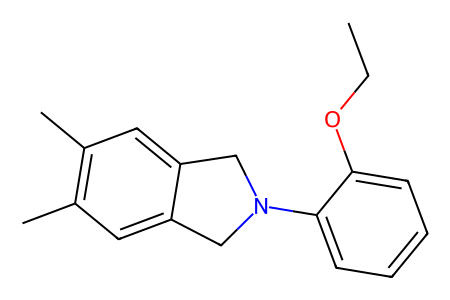

In [58]:
mc = Chem.MolFromSmiles(dataset[idx]['smiles'])
molSize=(450,300)
drawer = MD2.MolDraw2DSVG(molSize[0],molSize[1])
drawer.DrawMolecule(mc)
drawer.FinishDrawing()
svg = drawer.GetDrawingText()
display(SVG(svg.replace('svg:','')))

Generate the 3d molecule!

In [59]:
!pip install -q py3Dmol

In [60]:
import py3Dmol
xyz = Chem.MolToXYZBlock(mols_gen[idx])

view = py3Dmol.view(width=400, height=400)
view.addModel(xyz, 'xyz')
view.setStyle({'stick': {}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# **🧐Denoising trajectory visualization**

In [61]:
data = dataset[idx]

num_samples = max(data.pos_ref.size(0) // data.num_nodes, 1)
data_input = data.clone()
data_input['pos_ref'] = None
batch = repeat_data(data_input, num_samples).to(DEVICE)

# save more intermediate timesteps
save_steps = [999, 950, 900, 850, 800, 750, 700, 600, 650, 500, 400, 300, 200, 150, 100, 75, 50, 30, 20, 10, 5, 0]
pos_trajectory = {}
noise_levels = {}
mol_trajectory = {}

# initial configuration
pos_init = torch.randn(batch.num_nodes, 3).to(DEVICE)

with torch.no_grad():
    # scale initial sample
    pos = pos_init * sigmas[-1]

    for t in scheduler.timesteps:
        batch.pos = pos

        # generate geometry with model
        epsilon = model.forward(batch, t, sigma=sigmas[t], return_dict=False)[0]

        # Update
        reconstructed_pos = scheduler.step(epsilon, t, pos)["prev_sample"].to(DEVICE)

        pos = reconstructed_pos

        if torch.isnan(pos).any():
            print("NaN detected. Please restart.")
            raise FloatingPointError()

        # recenter graph of positions
        pos = pos - scatter_mean(pos, batch.batch, dim=0)[batch.batch]

        # optional clipping
        if clip_pos is not None:
            pos = torch.clamp(pos, min=-clip_pos, max=clip_pos)

        # save the chosen timestep
        if t.item() in save_steps:
            pos_trajectory[t.item()] = pos.clone().cpu()
            noise_levels[t.item()] = sigmas[t].item()

            mol_at_t = set_rdmol_positions(data.rdmol, pos.clone().cpu().numpy())
            mol_trajectory[t.item()] = mol_at_t

print(f"number of saved time steps: {len(pos_trajectory)}")

pos_gen = pos.cpu()

number of saved time steps: 22


In [62]:
from ipywidgets import interact

@interact(step_idx=(0, len(mol_trajectory)-1, 1))
def show_denoising_step_rdkit(step_idx=0):
    all_steps = sorted(mol_trajectory.keys(), reverse=True)
    step = all_steps[step_idx]

    # RDKit
    mol = mol_trajectory[step]
    xyz_block = Chem.MolToXYZBlock(mol)

    view = py3Dmol.view(width=600, height=500)
    view.addModel(xyz_block, 'xyz')
    view.setStyle({'stick': {'radius': 0.15}, 'sphere': {'radius': 0.25}})
    view.setBackgroundColor('white')
    view.zoomTo()

    print(f"Timestep: {step}, Noise level: σ = {noise_levels.get(step, 0):.3f}")
    view.show()